In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import random
from astropy.io import fits
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.table import Table, hstack

### Import the relevant files

In [2]:
hsc_cosmos_path= '/global/cscratch1/sd/damonge/HSC/HSC_processed/DEEP_COSMOS/DEEP_COSMOS_Catalog_i24.50.fits'
hdulist = fits.open(hsc_cosmos_path)
hsc_cosmos_data = hdulist[1].data
hsc_cosmos_columns= hdulist[1].columns

cosmos_path= '/global/cscratch1/sd/damonge/HSC/COSMOS2015_Laigle+_v1.1.fits'
hdulist = fits.open(cosmos_path)
cosmos_data = hdulist[1].data
cosmos_columns= hdulist[1].columns

In [ ]:
len(hsc_cosmos_data) #633442
len(cosmos_data) #1182108

### Cut COSMOS 30-band so they match HSC

See https://arxiv.org/pdf/1704.05988.pdf 3rd page on "COSMOS data" part 2, "Photo-z"

In [3]:
lim_indices = np.where((0.01 < cosmos_data['PHOTOZ']) & (9 > cosmos_data['PHOTOZ']) & (cosmos_data['TYPE'] == 0) & (cosmos_data['ZP_2'] < 0) & (cosmos_data['MASS_BEST'] > 7.5) 
            & (np.maximum(cosmos_data['ZPDF_H68'] - cosmos_data['ZPDF'], cosmos_data['ZPDF'] - cosmos_data['ZPDF_L68']) < 0.05*(1+cosmos_data['PHOTOZ']))
            & (cosmos_data['CHI2_BEST'] < cosmos_data['CHIS']) & (cosmos_data['CHI2_BEST']/cosmos_data['NBFILT'] < 5.))

cosmos_data_cut= cosmos_data[lim_indices] #length= 197640


/global/common/cori/software/python/3.6-anaconda-5.2/lib/python3.6/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()


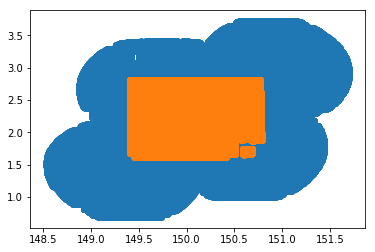

In [7]:
#blue- HSC, orange- COSMOS
plt.scatter(hsc_cosmos_data['ra'], hsc_cosmos_data['dec'])
plt.scatter(cosmos_data_cut['ALPHA_J2000'], cosmos_data_cut['DELTA_J2000'])


### Match the 30-band COSMOS to the HSC

In [29]:
cosmos_skycoord = SkyCoord(ra = cosmos_data_cut['ALPHA_J2000'] * u.deg, dec = cosmos_data_cut['DELTA_J2000']*u.deg)

hsc_skycoord = SkyCoord(ra = hsc_cosmos_data['ra'] * u.deg, dec = hsc_cosmos_data['dec'] * u.deg)
    
#hsc_index, dist_2d, dist_3d = cosmos_skycoord.match_to_catalog_sky(hsc_skycoord) This was for every cosmos, find a matching HSC

#Instead, I should do for every hsc, find matching COSMOS, as the hsc sample is much smaller and shallower
cosmos_index, dist_2d, dist_3d = hsc_skycoord.match_to_catalog_sky(cosmos_skycoord)

In [32]:
#cosmos_index is the indicies of cosmos_data_cut that match each of the hsc objects. Has same length as hsc_cosmos_data
#mask is a boolean array based on the distances of the resulting cosmos matches (True if dist<1arcsec)
mask=dist_2d.degree*60*60<1 #
cosmos_good=cosmos_data_cut[cosmos_index[mask]] #len= 101203
hsc_good=hsc_cosmos_data[mask] #len= 101203

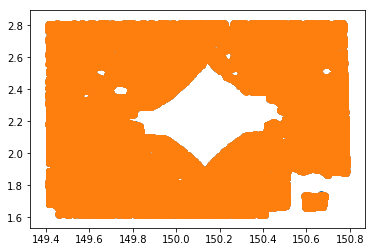

In [35]:
plt.scatter(cosmos_good['ALPHA_J2000'], cosmos_good['DELTA_J2000'])
plt.scatter(hsc_good['ra'], hsc_good['dec'])


(array([ 45762.,  42029.,   8254.,   2189.,   1030.,    612.,    399.,
           315.,    319.,    294.]),
 array([  6.50568491e-04,   1.00578187e-01,   2.00505805e-01,
          3.00433423e-01,   4.00361042e-01,   5.00288660e-01,
          6.00216278e-01,   7.00143897e-01,   8.00071515e-01,
          8.99999133e-01,   9.99926752e-01]),
 <a list of 10 Patch objects>)

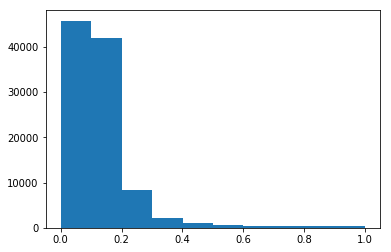

In [22]:
plt.hist(dist_2d[mask].degree*60*60)

### Make a fits file with this match

In [42]:
cosmos_good_df= pd.DataFrame(cosmos_good)
hsc_good_mag_df= pd.DataFrame(np.transpose([hsc_good['gcmodel_mag'], hsc_good['rcmodel_mag'], hsc_good['icmodel_mag'], hsc_good['zcmodel_mag'], hsc_good['ycmodel_mag']]),index=range(101203),columns=['gcmodel_mag','rcmodel_mag','icmodel_mag','zcmodel_mag','ycmodel_mag'] )

t1 = Table.from_pandas(cosmos_good_df)
t2 = Table.from_pandas(hsc_good_mag_df)

In [43]:
matched_catalog= hstack([t1, t2])
matched_catalog.write('../../../cosmos_matched_hsc_1arcsec.fits')

In [5]:
cosmos_matched_path= '../../../cosmos_matched_hsc_1arcsec.fits'
hdulist = fits.open(cosmos_matched_path)
cosmos_matched_data = hdulist[1].data
cosmos_matched_df= pd.DataFrame(cosmos_matched_data)